In [1]:
import numpy as np
# Vorherige Imports
import math
import time
import matplotlib.pyplot as plt
from colour import Color
from collections import Counter
import random
from time import gmtime, strftime
from numba import jit, njit
import pickle 
import odf2
import h5py

In [2]:
def load_dict(range_r = 6, factor = 10):
    with open(f'cache_dict_range_{range_r}_factor_{factor}.pkl', 'rb') as f:
        loaded_dict = pickle.load(f)
    return loaded_dict


def save_dict(dict_cache={}, range_r = 6, factor = 10):
    with open(f'cache_dict_range_{range_r}_factor_{factor}.pkl', 'wb') as f:
        pickle.dump(dict_cache, f)
    return


def get_array(dict_cache, key):
    return dict_cache[tuple(key)]


def koords_in_kegel_cache(range_r = 4, alpha = np.array([]), beta = np.array([])):
    # Winkel umdrehen, da Koordinatensystem gedreht wird anstatt der Punkte
    cos_alpha = np.cos(-alpha)
    sin_alpha = np.sin(-alpha)
    cos_beta = np.cos(-beta)
    sin_beta = np.sin(-beta)
    cos_alpha_cos_beta = cos_alpha*cos_beta
    sin_alpha_cos_beta = sin_alpha*cos_beta
    cos_alpha_sin_beta = cos_alpha*sin_beta
    sin_alpha_sin_beta = sin_alpha*sin_beta
    
    # erstelle das Gitter für x, y und z
    x = np.linspace(-range_r*2, range_r*2, range_r*4+1)
    y = np.copy(x)
    z = np.copy(x)
    length = int(((2*range_r)**3)/6)+1

    # Erstelle das Gitter für x, y und z
    x_grid, y_grid, z_grid = np.meshgrid(x, y, z)
    # test_x = np.copy(x_grid)
    result = np.empty((len(cos_alpha), 3, length)) * np.nan

    for i, ca, sa, cb, sb, cacb, sacb, casb, sasb in zip(range(len(cos_alpha)), cos_alpha, sin_alpha, cos_beta, sin_beta, cos_alpha_cos_beta, sin_alpha_cos_beta, cos_alpha_sin_beta, sin_alpha_sin_beta):
        # erst x achse dann y achse
        mask = (((ca*y_grid-sa*z_grid)**2 + (cacb*z_grid-sb*x_grid+sacb*y_grid)**2 < (casb*z_grid+sasb*y_grid+cb*x_grid)**2) & (0 < (casb*z_grid+sasb*y_grid+cb*x_grid)) & (range_r > (casb*z_grid+sasb*y_grid+cb*x_grid)))
        # x,y,z werte mit der spezifischen Maske auf die Kegel zuschneiden
        x_mask = x_grid[mask]
        y_mask = y_grid[mask]
        z_mask = z_grid[mask]
        data = np.array([x_mask, y_mask, z_mask])
        result[i,:,:np.shape(data)[1]] = data
    return result


def get_points(range_r):
    # Punkte vordefinieren
    x = np.arange(-range_r, range_r+1, 1)
    y = np.copy(x)
    z = np.copy(x)
    # erstelle das Gitter für x, y und z
    x_grid, y_grid, z_grid = np.meshgrid(x, y, z)
    # Punkte außerhalb des Kegels filtern 
    mask = (x_grid**2 + y_grid**2 + z_grid**2 <= (range_r+1)**2) & (x_grid**2 + y_grid**2 + z_grid**2 >= (range_r-1)**2)
    x_mask = x_grid[mask]
    y_mask = y_grid[mask]
    z_mask = z_grid[mask]
    # x, y, z zusammenfassen
    Kugelschale = np.concatenate((x_mask[:,None], y_mask[:,None], z_mask[:,None]), axis=1)
    # Kugelkoordinaten Winkel bestimmen
    beta = np.arccos(Kugelschale[:,0]/range_r)
    if np.sum(np.isnan(beta)) > 0:
        print(f"Warning, {np.sum(np.isnan(beta))} nan entries in beta!!!")
    alpha = np.arctan2(Kugelschale[:,2],Kugelschale[:,1])+math.pi/2
    if np.sum(np.isnan(alpha)) > 0:
        print(f"Warning, {np.sum(np.isnan(alpha))} nan entries in alpha!!!")
    return(Kugelschale, alpha, beta)


def generate_dict(range_r = 10, factor = 10):
    Kugelschale, alpha, beta = get_points(factor)
    temp_dict = {tuple(a_row): b_row for a_row, b_row in zip(Kugelschale, koords_in_kegel_cache(range_r, alpha, beta))}
    return temp_dict


def kegel_from_dict(dict_cache={}, factor=10, x_koord=0, y_koord=0, z_koord=0, alpha=np.array([]), beta=np.array([]), paralell_bool=False, get_phi_theta = False):
    # Winkelfunktionen vordefinieren
    cos_alpha = np.cos(alpha)
    sin_alpha = np.sin(alpha)
    cos_beta = np.cos(beta)
    sin_beta = np.sin(beta)
    # Karthesische Koordinate der symetrieachse berehnen
    x = (cos_beta)
    y = (sin_alpha*sin_beta)
    z = (-cos_alpha*sin_beta)
    koords = np.concatenate((x,y,z), axis=1)
    koords_rounded_int = np.array(np.round(koords*factor, 0), dtype=int)
    # Daten aus dem Dict herausholen
    if paralell_bool == False:
        arrays = [dict_cache[tuple(key)] for key in koords_rounded_int]
        result = np.array(arrays)
    # else:  # langsamer
    #     result = np.array(Parallel(n_jobs=-1)(delayed(get_array)(dict_cache,key) for key in koords_rounded_int))

    result[:,0,:] += x_koord
    result[:,1,:] += y_koord
    result[:,2,:] += z_koord
    if get_phi_theta == True:
        # Phi und Theta berechnen für ODFs
        phi = np.arccos(z)
        theta = np.arctan2(y,x)
        costheta = np.cos(theta)
        sintheta = np.sin(theta)
        return (result, phi, costheta, sintheta)

    return result


# anpassung der schnellen ungenauen berechnung der Kegel, da die Funktion zur bewertung der Punlte kontinuiertlich ist.
def reverse_rotate_and_translate_data(data, x_koord = 0, y_koord = 0, z_koord = 0, alpha = np.array([]), beta = np.array([])):
    # Translation Rückgängig machen
    data_ = np.copy(data)
    data_[:,0,:] -= x_koord
    data_[:,1,:] -= y_koord
    data_[:,2,:] -= z_koord
    # Für Optimierung Variablen vor definieren
    cos_alpha = np.cos(-alpha)
    sin_alpha = np.sin(-alpha)
    cos_beta = np.cos(-beta)
    sin_beta = np.sin(-beta)
    # Erzeuge Rotationsmatrizen für alle Winkel gleichzeitig
    rotation_matrix = np.empty((len(alpha), 3, 3))
    # Fülle die Rotationsmatrizen für alle Winkel gleichzeitig
    rotation_matrix[:, 0, 0] = cos_beta.ravel()
    rotation_matrix[:, 0, 1] = (sin_alpha*sin_beta).ravel()
    rotation_matrix[:, 0, 2] = (cos_alpha*sin_beta).ravel()

    rotation_matrix[:, 1, 0] = np.zeros_like(cos_beta).ravel()
    rotation_matrix[:, 1, 1] = cos_alpha.ravel()
    rotation_matrix[:, 1, 2] = -sin_alpha.ravel()

    rotation_matrix[:, 2, 0] = -sin_beta.ravel()
    rotation_matrix[:, 2, 1] = (sin_alpha*cos_beta).ravel()
    rotation_matrix[:, 2, 2] = (cos_alpha*cos_beta).ravel()
    # Wende die Rotationsmatrix auf die Daten an
    result = np.matmul(rotation_matrix, data_)
    result[:,0,:] += x_koord
    result[:,1,:] += y_koord
    result[:,2,:] += z_koord
    return result


def get_basis(phi:np.ndarray, costheta:np.ndarray, sintheta:np.ndarray, band:int)->np.ndarray:
    basis = np.empty((phi.shape[0], odf2.get_num_coeff(band)))
    for i, (p, ct, st) in enumerate(zip(phi, costheta, sintheta)):
        basis[i, :] = odf2._analytic_single_odf(ct, st, p, band)
    return basis


# def get_basis(phi:np.ndarray, costheta:np.ndarray, sintheta:np.ndarray, band:int)->np.ndarray:
#     basis = np.empty((phi.shape[0], odf.get_num_coeff(band)))
#     for i, (p, ct, st) in enumerate(zip(phi, costheta, sintheta)):
#         basis[i, :] = odf._analytic_single_odf(ct, st, p, band)
#     return basis


def gauss_3d(x,y,z,mu_x=0,mu_y=0,mu_z=0,sigma=2):
    return 1/(np.sqrt(math.pi*2)*sigma)*np.exp(-1/2*(((x-mu_x)/sigma)**2+((y-mu_y)/sigma)**2+((z-mu_z)/sigma)**2))


def gauss_2d(x,y,mu_x=0,mu_y=0,sigma=2):
    return 1/(np.sqrt(math.pi*2)*sigma)*np.exp(-1/2*(((x-mu_x)/sigma)**2+((y-mu_y)/sigma)**2))


def gauss_1d(x,mu_x=0,sigma=2):
    return 1/(np.sqrt(math.pi*2)*sigma)*np.exp(-1/2*(((x-mu_x)/sigma)**2))

In [3]:
def load_data(start, end):
    for i in range(end-start):
        if i == 0:
            f_mask = h5py.File(f'MSA_hdf5\MSA0309_M8_70mu_70ms_s0{start+i}_a00_d000_Mask.h5', 'r')
            f_Direction = h5py.File(f'MSA_hdf5\MSA0309_M8_70mu_70ms_s0{start+i}_ROFL_Direction.h5', 'r')
            f_Inclination = h5py.File(f'MSA_hdf5\MSA0309_M8_70mu_70ms_s0{start+i}_ROFL_Inclination.h5', 'r')
            f_rel = h5py.File(f'MSA_hdf5\MSA0309_M8_70mu_70ms_s0{start+i}_ROFL_T_rel.h5', 'r')
            f_mask_image = np.array(f_mask["Image"])[:,:,None]
            f_Direction_image = np.array(f_Direction["Image"])[:,:,None]
            f_Inclination_image = np.array(f_Inclination["Image"])[:,:,None]
            f_rel_image = np.array(f_rel["Image"])[:,:,None]
        else:
            f_mask1 = h5py.File(f'MSA_hdf5\MSA0309_M8_70mu_70ms_s0{start+i}_a00_d000_Mask.h5', 'r')
            f_Direction1 = h5py.File(f'MSA_hdf5\MSA0309_M8_70mu_70ms_s0{start+i}_ROFL_Direction.h5', 'r')
            f_Inclination1 = h5py.File(f'MSA_hdf5\MSA0309_M8_70mu_70ms_s0{start+i}_ROFL_Inclination.h5', 'r')
            f_rel1 = h5py.File(f'MSA_hdf5\MSA0309_M8_70mu_70ms_s0{start+i}_ROFL_T_rel.h5', 'r')
            f_mask_image1 = np.array(f_mask1["Image"])[:,:,None]
            f_Direction_image1 = np.array(f_Direction1["Image"])[:,:,None]
            f_Inclination_image1 = np.array(f_Inclination1["Image"])[:,:,None]
            f_rel_image1 = np.array(f_rel1["Image"])[:,:,None]
            f_mask_image = np.concatenate((f_mask_image, f_mask_image1), axis=2)
            f_Direction_image = np.concatenate((f_Direction_image, f_Direction_image1), axis=2)
            f_Inclination_image = np.concatenate((f_Inclination_image, f_Inclination_image1), axis=2)
            f_rel_image = np.concatenate((f_rel_image, f_rel_image1), axis=2)
    return (f_Direction_image, f_Inclination_image, f_mask_image, f_rel_image)


def test(result:np.ndarray, ODFs:np.ndarray, basis:np.ndarray, weights:np.ndarray)->np.ndarray:
    AODF_Amplitude = np.empty((result.shape[0]))
    for i, res in enumerate(result):
        # mask für nan werte
        nan_mask = ~np.isnan(res)
        mask = np.array(res[nan_mask], int)
        # shape anpassen
        mask_3d = np.reshape(mask, (3, int(mask.shape[0]/3)))
        # nur weights auswählen die nicht nan inhalte haben
        weight = weights[i, nan_mask[0]]
        Test_ODF_masked = np.multiply(weight, ODFs[mask_3d[0],mask_3d[1],mask_3d[2]-305].T).T
        current = np.multiply(basis[i], Test_ODF_masked)
        sum = np.sum(current)
        # if sum != 0.0:
        # print(sum,result.shape[0],res[0,~np.isnan(res[0])].shape[0])
        AODF_Amplitude[i] = sum/res[0,~np.isnan(res[0])].shape[0]
    return AODF_Amplitude

In [4]:
range_r, factor = 5, 100
dict_10_50 = generate_dict(range_r, factor) 

In [5]:
Direction_image, Inclination_image, mask_image, rel_image = load_data(300, 310)

In [ ]:
band = 10
ODFs = odf2.compute(Direction_image[:,:,:,None], Inclination_image[:,:,:,None], mask_image[:,:,:,None], band)

In [28]:

x_koord, y_koord, z_koord = 605,605,305
number_of_winkel = 1000

rng = np.random.default_rng(random.randint(100000,10000000000))
beta = np.arccos(1-2*(rng.random(number_of_winkel).reshape(number_of_winkel,1)))
alpha = rng.random(number_of_winkel).reshape(number_of_winkel,1)*math.pi*2

result, phi, costheta, sintheta = kegel_from_dict(dict_10_50, factor, x_koord, y_koord, z_koord, alpha, beta, get_phi_theta=True)
result_rot = reverse_rotate_and_translate_data(result, x_koord, y_koord, z_koord, alpha, beta)
weights = gauss_2d(result_rot[:,1,:], result_rot[:,2,:], y_koord, z_koord, sigma = 2)


basis = get_basis(phi, costheta, sintheta, band)

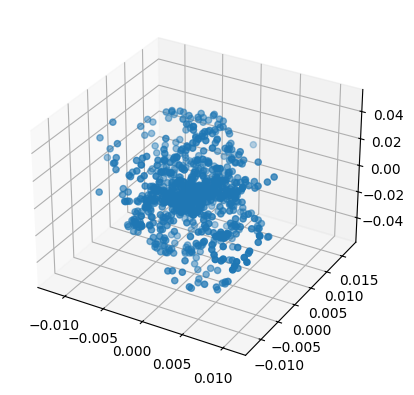

In [29]:
AODF_Amplitude = test(result, ODFs, basis, weights)

x = AODF_Amplitude[:,None] * np.cos(phi) * sintheta
y = AODF_Amplitude[:,None] * np.sin(phi) * sintheta
z = AODF_Amplitude[:,None] * costheta
fig = plt.figure()
ax = fig.add_subplot(projection = "3d")
n = 1000
ax.scatter(x[:n],y[:n],z[:n])
plt.show()

In [21]:
band = 6
ODFs = odf2.compute(Direction_image[:,:,:,None], Inclination_image[:,:,:,None], mask_image[:,:,:,None], band)



In [25]:
odf2.coefficients_to_mrtrix_nii(f"Test_200umgebung_{band}band", ODFs[500:700,500:700,:,:])

In [23]:
odf2.coefficients_to_mrtrix_nii(f"Test_200umgebung_{band}band_small", ODFs[604:606,604:606,4:6,:])

## ODF3 stand 29.11

In [1]:
import numpy as np
# Vorherige Imports
import math
import time
import matplotlib.pyplot as plt
from colour import Color
from collections import Counter
import random
from time import gmtime, strftime
from numba import jit, njit
import pickle 
import odf3
import h5py

In [2]:
def load_dict(range_r = 6, factor = 10):
    with open(f'cache_dict_range_{range_r}_factor_{factor}.pkl', 'rb') as f:
        loaded_dict = pickle.load(f)
    return loaded_dict


def save_dict(dict_cache={}, range_r = 6, factor = 10):
    with open(f'cache_dict_range_{range_r}_factor_{factor}.pkl', 'wb') as f:
        pickle.dump(dict_cache, f)
    return


def get_array(dict_cache, key):
    return dict_cache[tuple(key)]


def koords_in_kegel_cache(range_r = 4, alpha = np.array([]), beta = np.array([])):
    # Winkel umdrehen, da Koordinatensystem gedreht wird anstatt der Punkte
    cos_alpha = np.cos(-alpha)
    sin_alpha = np.sin(-alpha)
    cos_beta = np.cos(-beta)
    sin_beta = np.sin(-beta)
    cos_alpha_cos_beta = cos_alpha*cos_beta
    sin_alpha_cos_beta = sin_alpha*cos_beta
    cos_alpha_sin_beta = cos_alpha*sin_beta
    sin_alpha_sin_beta = sin_alpha*sin_beta
    
    # erstelle das Gitter für x, y und z
    x = np.linspace(-range_r*2, range_r*2, range_r*4+1)
    y = np.copy(x)
    z = np.copy(x)
    length = int(((2*range_r)**3)/6)+1

    # Erstelle das Gitter für x, y und z
    x_grid, y_grid, z_grid = np.meshgrid(x, y, z)
    # test_x = np.copy(x_grid)
    result = np.empty((len(cos_alpha), 3, length)) * np.nan

    for i, ca, sa, cb, sb, cacb, sacb, casb, sasb in zip(range(len(cos_alpha)), cos_alpha, sin_alpha, cos_beta, sin_beta, cos_alpha_cos_beta, sin_alpha_cos_beta, cos_alpha_sin_beta, sin_alpha_sin_beta):
        # erst x achse dann y achse
        mask = (((ca*y_grid-sa*z_grid)**2 + (cacb*z_grid-sb*x_grid+sacb*y_grid)**2 < (casb*z_grid+sasb*y_grid+cb*x_grid)**2) & (0 < (casb*z_grid+sasb*y_grid+cb*x_grid)) & (range_r > (casb*z_grid+sasb*y_grid+cb*x_grid)))
        # x,y,z werte mit der spezifischen Maske auf die Kegel zuschneiden
        x_mask = x_grid[mask]
        y_mask = y_grid[mask]
        z_mask = z_grid[mask]
        data = np.array([x_mask, y_mask, z_mask])
        result[i,:,:np.shape(data)[1]] = data
    return result


def get_points(range_r):
    # Punkte vordefinieren
    x = np.arange(-range_r, range_r+1, 1)
    y = np.copy(x)
    z = np.copy(x)
    # erstelle das Gitter für x, y und z
    x_grid, y_grid, z_grid = np.meshgrid(x, y, z)
    # Punkte außerhalb des Kegels filtern 
    mask = (x_grid**2 + y_grid**2 + z_grid**2 <= (range_r+1)**2) & (x_grid**2 + y_grid**2 + z_grid**2 >= (range_r-1)**2)
    x_mask = x_grid[mask]
    y_mask = y_grid[mask]
    z_mask = z_grid[mask]
    # x, y, z zusammenfassen
    Kugelschale = np.concatenate((x_mask[:,None], y_mask[:,None], z_mask[:,None]), axis=1)
    # Kugelkoordinaten Winkel bestimmen
    beta = np.arccos(Kugelschale[:,0]/range_r)
    if np.sum(np.isnan(beta)) > 0:
        print(f"Warning, {np.sum(np.isnan(beta))} nan entries in beta!!!")
    alpha = np.arctan2(Kugelschale[:,2],Kugelschale[:,1])+math.pi/2
    if np.sum(np.isnan(alpha)) > 0:
        print(f"Warning, {np.sum(np.isnan(alpha))} nan entries in alpha!!!")
    return(Kugelschale, alpha, beta)


def generate_dict(range_r = 10, factor = 10):
    Kugelschale, alpha, beta = get_points(factor)
    temp_dict = {tuple(a_row): b_row for a_row, b_row in zip(Kugelschale, koords_in_kegel_cache(range_r, alpha, beta))}
    return temp_dict


def kegel_from_dict(dict_cache={}, factor=10, x_koord=0, y_koord=0, z_koord=0, alpha=np.array([]), beta=np.array([]), paralell_bool=False, get_phi_theta = False):
    # Winkelfunktionen vordefinieren
    cos_alpha = np.cos(alpha)
    sin_alpha = np.sin(alpha)
    cos_beta = np.cos(beta)
    sin_beta = np.sin(beta)
    # Karthesische Koordinate der symetrieachse berehnen
    x = (cos_beta)
    y = (sin_alpha*sin_beta)
    z = (-cos_alpha*sin_beta)
    koords = np.concatenate((x,y,z), axis=1)
    koords_rounded_int = np.array(np.round(koords*factor, 0), dtype=int)
    # Daten aus dem Dict herausholen
    if paralell_bool == False:
        arrays = [dict_cache[tuple(key)] for key in koords_rounded_int]
        result = np.array(arrays)
    # else:  # langsamer
    #     result = np.array(Parallel(n_jobs=-1)(delayed(get_array)(dict_cache,key) for key in koords_rounded_int))

    result[:,0,:] += x_koord
    result[:,1,:] += y_koord
    result[:,2,:] += z_koord
    if get_phi_theta == True:
        # Phi und Theta berechnen für ODFs
        phi = np.arccos(z)
        theta = np.arctan2(y,x)
        costheta = np.cos(theta)
        sintheta = np.sin(theta)
        return (result, phi, costheta, sintheta)

    return result


# anpassung der schnellen ungenauen berechnung der Kegel, da die Funktion zur bewertung der Punlte kontinuiertlich ist.
def reverse_rotate_and_translate_data(data, x_koord = 0, y_koord = 0, z_koord = 0, alpha = np.array([]), beta = np.array([])):
    # Translation Rückgängig machen
    data_ = np.copy(data)
    data_[:,0,:] -= x_koord
    data_[:,1,:] -= y_koord
    data_[:,2,:] -= z_koord
    # Für Optimierung Variablen vor definieren
    cos_alpha = np.cos(-alpha)
    sin_alpha = np.sin(-alpha)
    cos_beta = np.cos(-beta)
    sin_beta = np.sin(-beta)
    # Erzeuge Rotationsmatrizen für alle Winkel gleichzeitig
    rotation_matrix = np.empty((len(alpha), 3, 3))
    # Fülle die Rotationsmatrizen für alle Winkel gleichzeitig
    rotation_matrix[:, 0, 0] = cos_beta.ravel()
    rotation_matrix[:, 0, 1] = (sin_alpha*sin_beta).ravel()
    rotation_matrix[:, 0, 2] = (cos_alpha*sin_beta).ravel()

    rotation_matrix[:, 1, 0] = np.zeros_like(cos_beta).ravel()
    rotation_matrix[:, 1, 1] = cos_alpha.ravel()
    rotation_matrix[:, 1, 2] = -sin_alpha.ravel()

    rotation_matrix[:, 2, 0] = -sin_beta.ravel()
    rotation_matrix[:, 2, 1] = (sin_alpha*cos_beta).ravel()
    rotation_matrix[:, 2, 2] = (cos_alpha*cos_beta).ravel()
    # Wende die Rotationsmatrix auf die Daten an
    result = np.matmul(rotation_matrix, data_)
    result[:,0,:] += x_koord
    result[:,1,:] += y_koord
    result[:,2,:] += z_koord
    return result


def get_basis(phi:np.ndarray, costheta:np.ndarray, sintheta:np.ndarray, band:int)->np.ndarray:
    basis = np.empty((phi.shape[0], odf3.get_num_coeff(band)))
    for i, (p, ct, st) in enumerate(zip(phi, costheta, sintheta)):
        basis[i, :] = odf3._analytic_single_odf(ct, st, p, band)
    return basis


# def get_basis(phi:np.ndarray, costheta:np.ndarray, sintheta:np.ndarray, band:int)->np.ndarray:
#     basis = np.empty((phi.shape[0], odf.get_num_coeff(band)))
#     for i, (p, ct, st) in enumerate(zip(phi, costheta, sintheta)):
#         basis[i, :] = odf._analytic_single_odf(ct, st, p, band)
#     return basis


def gauss_3d(x,y,z,mu_x=0,mu_y=0,mu_z=0,sigma=2):
    return 1/(np.sqrt(math.pi*2)*sigma)*np.exp(-1/2*(((x-mu_x)/sigma)**2+((y-mu_y)/sigma)**2+((z-mu_z)/sigma)**2))


def gauss_2d(x,y,mu_x=0,mu_y=0,sigma=2):
    return 1/(np.sqrt(math.pi*2)*sigma)*np.exp(-1/2*(((x-mu_x)/sigma)**2+((y-mu_y)/sigma)**2))


def gauss_1d(x,mu_x=0,sigma=2):
    return 1/(np.sqrt(math.pi*2)*sigma)*np.exp(-1/2*(((x-mu_x)/sigma)**2))

In [3]:
def load_data(start, end):
    for i in range(end-start):
        if i == 0:
            f_mask = h5py.File(f'MSA_hdf5\MSA0309_M8_70mu_70ms_s0{start+i}_a00_d000_Mask.h5', 'r')
            f_Direction = h5py.File(f'MSA_hdf5\MSA0309_M8_70mu_70ms_s0{start+i}_ROFL_Direction.h5', 'r')
            f_Inclination = h5py.File(f'MSA_hdf5\MSA0309_M8_70mu_70ms_s0{start+i}_ROFL_Inclination.h5', 'r')
            f_rel = h5py.File(f'MSA_hdf5\MSA0309_M8_70mu_70ms_s0{start+i}_ROFL_T_rel.h5', 'r')
            f_mask_image = np.array(f_mask["Image"])[:,:,None]
            f_Direction_image = np.array(f_Direction["Image"])[:,:,None]
            f_Inclination_image = np.array(f_Inclination["Image"])[:,:,None]
            f_rel_image = np.array(f_rel["Image"])[:,:,None]
        else:
            f_mask1 = h5py.File(f'MSA_hdf5\MSA0309_M8_70mu_70ms_s0{start+i}_a00_d000_Mask.h5', 'r')
            f_Direction1 = h5py.File(f'MSA_hdf5\MSA0309_M8_70mu_70ms_s0{start+i}_ROFL_Direction.h5', 'r')
            f_Inclination1 = h5py.File(f'MSA_hdf5\MSA0309_M8_70mu_70ms_s0{start+i}_ROFL_Inclination.h5', 'r')
            f_rel1 = h5py.File(f'MSA_hdf5\MSA0309_M8_70mu_70ms_s0{start+i}_ROFL_T_rel.h5', 'r')
            f_mask_image1 = np.array(f_mask1["Image"])[:,:,None]
            f_Direction_image1 = np.array(f_Direction1["Image"])[:,:,None]
            f_Inclination_image1 = np.array(f_Inclination1["Image"])[:,:,None]
            f_rel_image1 = np.array(f_rel1["Image"])[:,:,None]
            f_mask_image = np.concatenate((f_mask_image, f_mask_image1), axis=2)
            f_Direction_image = np.concatenate((f_Direction_image, f_Direction_image1), axis=2)
            f_Inclination_image = np.concatenate((f_Inclination_image, f_Inclination_image1), axis=2)
            f_rel_image = np.concatenate((f_rel_image, f_rel_image1), axis=2)
    return (f_Direction_image, f_Inclination_image, f_mask_image, f_rel_image)


def test(result:np.ndarray, ODFs:np.ndarray, basis:np.ndarray, weights:np.ndarray)->np.ndarray:
    AODF_Amplitude = np.empty((result.shape[0]))
    for i, res in enumerate(result):
        # mask für nan werte
        nan_mask = ~np.isnan(res)
        mask = np.array(res[nan_mask], int)
        # shape anpassen
        mask_3d = np.reshape(mask, (3, int(mask.shape[0]/3)))
        # nur weights auswählen die nicht nan inhalte haben
        weight = weights[i, nan_mask[0]]
        Test_ODF_masked = np.multiply(weight, ODFs[mask_3d[0],mask_3d[1],mask_3d[2]-305].T).T
        current = np.multiply(basis[i], Test_ODF_masked)
        sum = np.sum(current)
        # if sum != 0.0:
        # print(sum,result.shape[0],res[0,~np.isnan(res[0])].shape[0])
        AODF_Amplitude[i] = sum/res[0,~np.isnan(res[0])].shape[0]
    return AODF_Amplitude

In [4]:
range_r, factor = 5, 100
dict_10_50 = generate_dict(range_r, factor) 

In [5]:
Direction_image, Inclination_image, mask_image, rel_image = load_data(300, 310)

In [6]:
band = 12
ODFs = odf3.compute(np.deg2rad(Direction_image[:,:,:,None]), np.deg2rad(Inclination_image[:,:,:,None]), mask_image[:,:,:,None], band)

In [7]:
x_koord, y_koord, z_koord = 605,605,305
number_of_winkel = 1000

rng = np.random.default_rng(random.randint(100000,10000000000))
beta = np.arccos(1-2*(rng.random(number_of_winkel).reshape(number_of_winkel,1)))
alpha = rng.random(number_of_winkel).reshape(number_of_winkel,1)*math.pi*2

result, phi, costheta, sintheta = kegel_from_dict(dict_10_50, factor, x_koord, y_koord, z_koord, alpha, beta, get_phi_theta=True)
result_rot = reverse_rotate_and_translate_data(result, x_koord, y_koord, z_koord, alpha, beta)
weights = gauss_2d(result_rot[:,1,:], result_rot[:,2,:], y_koord, z_koord, sigma = 2)


basis = get_basis(phi, costheta, sintheta, band)

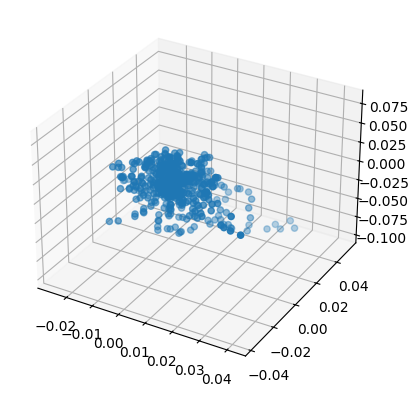

In [8]:
AODF_Amplitude = test(result, ODFs, basis, weights)

x = AODF_Amplitude[:,None] * np.cos(phi) * sintheta
y = AODF_Amplitude[:,None] * np.sin(phi) * sintheta
z = AODF_Amplitude[:,None] * costheta
fig = plt.figure()
ax = fig.add_subplot(projection = "3d")
n = 1000
ax.scatter(x[:n],y[:n],z[:n])
plt.show()

oberfläche an odf fitten ---
mit allen bändern sapling werte in die ODF berechung geben

In [12]:
band = 12
ODFs = odf3.compute(Direction_image[:,:,:,None], Inclination_image[:,:,:,None], mask_image[:,:,:,None], band)



array shape x/3,etc
3*x bis 

In [9]:
odf3.coefficients_to_mrtrix_nii(f"odf3_deg_Test_200umgebung_{band}band", ODFs[500:700,500:700,:,:])

In [10]:
odf3.coefficients_to_mrtrix_nii(f"odf3_deg_Test_200umgebung_{band}band_small", ODFs[604:606,604:606,4:6,:])

# ODFs aus mehr pixeln berechnen

In [11]:
import numpy as np
# Vorherige Imports
import math
import time
import matplotlib.pyplot as plt
from colour import Color
from collections import Counter
import random
from time import gmtime, strftime
from numba import jit, njit
import pickle 
import odf2
import h5py


def load_data(start, end):
    for i in range(end-start):
        if i == 0:
            f_mask = h5py.File(f'MSA_hdf5\MSA0309_M8_70mu_70ms_s0{start+i}_a00_d000_Mask.h5', 'r')
            f_Direction = h5py.File(f'MSA_hdf5\MSA0309_M8_70mu_70ms_s0{start+i}_ROFL_Direction.h5', 'r')
            f_Inclination = h5py.File(f'MSA_hdf5\MSA0309_M8_70mu_70ms_s0{start+i}_ROFL_Inclination.h5', 'r')
            f_rel = h5py.File(f'MSA_hdf5\MSA0309_M8_70mu_70ms_s0{start+i}_ROFL_T_rel.h5', 'r')
            f_mask_image = np.array(f_mask["Image"])[:,:,None]
            f_Direction_image = np.array(f_Direction["Image"])[:,:,None]
            f_Inclination_image = np.array(f_Inclination["Image"])[:,:,None]
            f_rel_image = np.array(f_rel["Image"])[:,:,None]
        else:
            f_mask1 = h5py.File(f'MSA_hdf5\MSA0309_M8_70mu_70ms_s0{start+i}_a00_d000_Mask.h5', 'r')
            f_Direction1 = h5py.File(f'MSA_hdf5\MSA0309_M8_70mu_70ms_s0{start+i}_ROFL_Direction.h5', 'r')
            f_Inclination1 = h5py.File(f'MSA_hdf5\MSA0309_M8_70mu_70ms_s0{start+i}_ROFL_Inclination.h5', 'r')
            f_rel1 = h5py.File(f'MSA_hdf5\MSA0309_M8_70mu_70ms_s0{start+i}_ROFL_T_rel.h5', 'r')
            f_mask_image1 = np.array(f_mask1["Image"])[:,:,None]
            f_Direction_image1 = np.array(f_Direction1["Image"])[:,:,None]
            f_Inclination_image1 = np.array(f_Inclination1["Image"])[:,:,None]
            f_rel_image1 = np.array(f_rel1["Image"])[:,:,None]
            f_mask_image = np.concatenate((f_mask_image, f_mask_image1), axis=2)
            f_Direction_image = np.concatenate((f_Direction_image, f_Direction_image1), axis=2)
            f_Inclination_image = np.concatenate((f_Inclination_image, f_Inclination_image1), axis=2)
            f_rel_image = np.concatenate((f_rel_image, f_rel_image1), axis=2)
    return (f_Direction_image, f_Inclination_image, f_mask_image, f_rel_image)


def test(result:np.ndarray, ODFs:np.ndarray, basis:np.ndarray, weights:np.ndarray)->np.ndarray:
    AODF_Amplitude = np.empty((result.shape[0]))
    for i, res in enumerate(result):
        # mask für nan werte
        nan_mask = ~np.isnan(res)
        mask = np.array(res[nan_mask], int)
        # shape anpassen
        mask_3d = np.reshape(mask, (3, int(mask.shape[0]/3)))
        # nur weights auswählen die nicht nan inhalte haben
        weight = weights[i, nan_mask[0]]
        Test_ODF_masked = np.multiply(weight, ODFs[mask_3d[0],mask_3d[1],mask_3d[2]-305].T).T
        current = np.multiply(basis[i], Test_ODF_masked)
        sum = np.sum(current)
        # if sum != 0.0:
        # print(sum,result.shape[0],res[0,~np.isnan(res[0])].shape[0])
        AODF_Amplitude[i] = sum/res[0,~np.isnan(res[0])].shape[0]
    return AODF_Amplitude

In [12]:
Direction_image, Inclination_image, mask_image, rel_image = load_data(300, 310)

In [ ]:
band = 12
ODFs = odf3.compute(Direction_image[:,:,:,None], Inclination_image[:,:,:,None], mask_image[:,:,:,None], band)

In [16]:
np.empty((*Direction_image.shape,3,3,3)).shape

(1278, 1821, 10, 3, 3, 3)

In [39]:
test_lst = np.broadcast_to(Direction_image[:, :, :, np.newaxis, np.newaxis, np.newaxis], (1278, 1821, 10, 3, 3, 3))
test_lst.shape

(1278, 1821, 10, 3, 3, 3)

In [46]:
test_lst[600,600,5,:,:,:]

array([[[123.86066, 123.86066, 123.86066],
        [123.86066, 123.86066, 123.86066],
        [123.86066, 123.86066, 123.86066]],

       [[123.86066, 123.86066, 123.86066],
        [123.86066, 123.86066, 123.86066],
        [123.86066, 123.86066, 123.86066]],

       [[123.86066, 123.86066, 123.86066],
        [123.86066, 123.86066, 123.86066],
        [123.86066, 123.86066, 123.86066]]], dtype=float32)

In [53]:
Test_lst = lambda i,j,k: np.array([
    [
        [Direction_image[i,j,k],Direction_image[i,j,k+1],Direction_image[i,j,k+2]],
        [Direction_image[i+1,j,k],Direction_image[i+1,j,k+1],Direction_image[i+1,j,k+2]],
        [Direction_image[i+2,j,k],Direction_image[i+2,j,k+1],Direction_image[i+2,j,k+2]],],
    [
        [Direction_image[i,j,k],Direction_image[i+1,j,k],Direction_image[i+2,j,k]],
        [Direction_image[i,j+1,k],Direction_image[i+1,j+1,k],Direction_image[i+2,j+1,k]],
        [Direction_image[i,j+2,k],Direction_image[i+1,j+2,k],Direction_image[i+2,j+2,k]],],
    [
        [Direction_image[i,j,k],Direction_image[i+1,j,k],Direction_image[i+2,j,k]],
        [Direction_image[i,j,k+1],Direction_image[i,j+1,k+1],Direction_image[i,j+2,k+1]],
        [Direction_image[i,j,k+2],Direction_image[i,j+1,k+2],Direction_image[i,j+2,k+2]]]])

In [60]:
test_lst = np.empty((3,3,3))*0
test_lst[1,0,:] = [1,2,3]
test_lst

array([[[0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.]],

       [[1., 2., 3.],
        [0., 0., 0.],
        [0., 0., 0.]],

       [[0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.]]])

In [73]:
Inclination_image.shape, Inclination_image_three_by_three.shape

((1278, 1821, 10), (3, 3, 3))

In [80]:
Direction_image_three_by_three = np.copy(np.broadcast_to(Direction_image[500:600,500:600, :, np.newaxis, np.newaxis, np.newaxis], (*Direction_image[500:600,500:600,:].shape, 3, 3, 3)))
Inclination_image_three_by_three = np.copy(np.broadcast_to(Inclination_image[500:600,500:600, :, np.newaxis, np.newaxis, np.newaxis], (*Inclination_image[500:600,500:600,:].shape, 3, 3, 3)))
mask_image_three_by_three = np.copy(np.broadcast_to(mask_image[500:600, 500:600, :, np.newaxis, np.newaxis, np.newaxis], (*mask_image[500:600,500:600,:].shape, 3, 3, 3)))

def three_by_three(ndarray, i,j,k):
    result = np.array([
        [
            [ndarray[i,j,k],ndarray[i,j,k+1],ndarray[i,j,k+2]],
            [ndarray[i,j+1,k],ndarray[i,j+1,k+1],ndarray[i,j+1,k+2]],
            [ndarray[i,j+2,k],ndarray[i,j+2,k+1],ndarray[i,j+2,k+2]]],
        [
            [ndarray[i+1,j,k],ndarray[i+1,j,k+1],ndarray[i+1,j,k+2]],
            [ndarray[i+1,j+1,k],ndarray[i+1,j+1,k+1],ndarray[i+1,j+1,k+2]],
            [ndarray[i+1,j+2,k],ndarray[i+1,j+2,k+1],ndarray[i+1,j+2,k+2]]],
        [
            [ndarray[i+2,j,k],ndarray[i+2,j,k+1],ndarray[i+2,j,k+2]],
            [ndarray[i+2,j+1,k],ndarray[i+2,j+1,k+1],ndarray[i+2,j+1,k+2]],
            [ndarray[i+2,j+2,k],ndarray[i+2,j+2,k+1],ndarray[i+2,j+2,k+2]]]])
    return result


for i in range(Direction_image_three_by_three.shape[0]-3):
    for j in range(Direction_image_three_by_three.shape[1]-3):
        for k in range(Direction_image_three_by_three.shape[2]-3):
            Direction_image_three_by_three[i,j,k,:,:,:] = three_by_three(Direction_image,i,j,k)
            Inclination_image_three_by_three[i,j,k,:,:,:] = three_by_three(Inclination_image,i,j,k)
            mask_image_three_by_three[i,j,k,:,:,:] = three_by_three(mask_image,i,j,k)



In [81]:
np.save("Direction_300to310_3x3x3",Direction_image_three_by_three)
np.save("Inclination_300to310_3x3x3",Inclination_image_three_by_three)
np.save("mask_300to310_3x3x3",mask_image_three_by_three)

In [90]:
band = 5
ODFs_test = odf3.compute(Direction_image[500:600,500:600,:,None], Inclination_image[500:600,500:600,:,None], mask_image[500:600,500:600,:,None], band)

In [91]:
ODFs_test.shape

(100, 100, 10, 15)

In [82]:
Direction_image_three_by_three.shape, Inclination_image_three_by_three.shape

((100, 100, 10, 3, 3, 3), (100, 100, 10, 3, 3, 3))

In [88]:
band = 5
ODFs = odf3.compute(np.deg2rad(Direction_image_three_by_three), np.deg2rad(Inclination_image_three_by_three), mask_image_three_by_three, band)

In [89]:
ODFs.shape

(100, 100, 10, 3, 3, 15)

In [84]:
odf3.coefficients_to_mrtrix_nii(f"3d_odf3_deg_Test_100umgebung_{band}band", ODFs[:,:,:,:])

AssertionError: 

# shape: (x,y,z,27)

In [1]:
import numpy as np
# Vorherige Imports
import math
import time
import matplotlib.pyplot as plt
from colour import Color
from collections import Counter
import random
from time import gmtime, strftime
from numba import jit, njit
import pickle 
import odf3
import h5py


def load_data(start, end):
    for i in range(end-start):
        if i == 0:
            f_mask = h5py.File(f'MSA_hdf5\MSA0309_M8_70mu_70ms_s0{start+i}_a00_d000_Mask.h5', 'r')
            f_Direction = h5py.File(f'MSA_hdf5\MSA0309_M8_70mu_70ms_s0{start+i}_ROFL_Direction.h5', 'r')
            f_Inclination = h5py.File(f'MSA_hdf5\MSA0309_M8_70mu_70ms_s0{start+i}_ROFL_Inclination.h5', 'r')
            f_rel = h5py.File(f'MSA_hdf5\MSA0309_M8_70mu_70ms_s0{start+i}_ROFL_T_rel.h5', 'r')
            f_mask_image = np.array(f_mask["Image"])[:,:,None]
            f_Direction_image = np.array(f_Direction["Image"])[:,:,None]
            f_Inclination_image = np.array(f_Inclination["Image"])[:,:,None]
            f_rel_image = np.array(f_rel["Image"])[:,:,None]
        else:
            f_mask1 = h5py.File(f'MSA_hdf5\MSA0309_M8_70mu_70ms_s0{start+i}_a00_d000_Mask.h5', 'r')
            f_Direction1 = h5py.File(f'MSA_hdf5\MSA0309_M8_70mu_70ms_s0{start+i}_ROFL_Direction.h5', 'r')
            f_Inclination1 = h5py.File(f'MSA_hdf5\MSA0309_M8_70mu_70ms_s0{start+i}_ROFL_Inclination.h5', 'r')
            f_rel1 = h5py.File(f'MSA_hdf5\MSA0309_M8_70mu_70ms_s0{start+i}_ROFL_T_rel.h5', 'r')
            f_mask_image1 = np.array(f_mask1["Image"])[:,:,None]
            f_Direction_image1 = np.array(f_Direction1["Image"])[:,:,None]
            f_Inclination_image1 = np.array(f_Inclination1["Image"])[:,:,None]
            f_rel_image1 = np.array(f_rel1["Image"])[:,:,None]
            f_mask_image = np.concatenate((f_mask_image, f_mask_image1), axis=2)
            f_Direction_image = np.concatenate((f_Direction_image, f_Direction_image1), axis=2)
            f_Inclination_image = np.concatenate((f_Inclination_image, f_Inclination_image1), axis=2)
            f_rel_image = np.concatenate((f_rel_image, f_rel_image1), axis=2)
    return (f_Direction_image, f_Inclination_image, f_mask_image, f_rel_image)


def test(result:np.ndarray, ODFs:np.ndarray, basis:np.ndarray, weights:np.ndarray)->np.ndarray:
    AODF_Amplitude = np.empty((result.shape[0]))
    for i, res in enumerate(result):
        # mask für nan werte
        nan_mask = ~np.isnan(res)
        mask = np.array(res[nan_mask], int)
        # shape anpassen
        mask_3d = np.reshape(mask, (3, int(mask.shape[0]/3)))
        # nur weights auswählen die nicht nan inhalte haben
        weight = weights[i, nan_mask[0]]
        Test_ODF_masked = np.multiply(weight, ODFs[mask_3d[0],mask_3d[1],mask_3d[2]-305].T).T
        current = np.multiply(basis[i], Test_ODF_masked)
        sum = np.sum(current)
        # if sum != 0.0:
        # print(sum,result.shape[0],res[0,~np.isnan(res[0])].shape[0])
        AODF_Amplitude[i] = sum/res[0,~np.isnan(res[0])].shape[0]
    return AODF_Amplitude

In [2]:
Direction_image, Inclination_image, mask_image, rel_image = load_data(300, 310)

In [3]:
Direction_image_three_by_three = np.copy(np.broadcast_to(Direction_image[500:600,500:600, :, np.newaxis], (*Direction_image[500:600,500:600,:].shape, 27)))
Inclination_image_three_by_three = np.copy(np.broadcast_to(Inclination_image[500:600,500:600, :, np.newaxis], (*Inclination_image[500:600,500:600,:].shape, 27)))
mask_image_three_by_three = np.copy(np.broadcast_to(mask_image[500:600, 500:600, :, np.newaxis], (*mask_image[500:600,500:600,:].shape, 27)))

def three_by_three(ndarray, i,j,k):
    result = np.array([
        ndarray[i,j,k],ndarray[i,j,k+1],ndarray[i,j,k+2],
        ndarray[i,j+1,k],ndarray[i,j+1,k+1],ndarray[i,j+1,k+2],
        ndarray[i,j+2,k],ndarray[i,j+2,k+1],ndarray[i,j+2,k+2],
        ndarray[i+1,j,k],ndarray[i+1,j,k+1],ndarray[i+1,j,k+2],
        ndarray[i+1,j+1,k],ndarray[i+1,j+1,k+1],ndarray[i+1,j+1,k+2],
        ndarray[i+1,j+2,k],ndarray[i+1,j+2,k+1],ndarray[i+1,j+2,k+2],
        ndarray[i+2,j,k],ndarray[i+2,j,k+1],ndarray[i+2,j,k+2],
        ndarray[i+2,j+1,k],ndarray[i+2,j+1,k+1],ndarray[i+2,j+1,k+2],
        ndarray[i+2,j+2,k],ndarray[i+2,j+2,k+1],ndarray[i+2,j+2,k+2]])
    return result


for i in range(Direction_image_three_by_three.shape[0]-3):
    for j in range(Direction_image_three_by_three.shape[1]-3):
        for k in range(Direction_image_three_by_three.shape[2]-3):
            Direction_image_three_by_three[i+1,j+1,k+1,:] = three_by_three(Direction_image,i,j,k)
            Inclination_image_three_by_three[i+1,j+1,k+1,:] = three_by_three(Inclination_image,i,j,k)
            mask_image_three_by_three[i+1,j+1,k+1,:] = three_by_three(mask_image,i,j,k)



In [4]:
band = 12
ODFs = odf3.compute(np.deg2rad(Direction_image_three_by_three), np.deg2rad(Inclination_image_three_by_three), mask_image_three_by_three, band)

In [5]:
ODFs.shape

(100, 100, 10, 91)

In [6]:
odf3.coefficients_to_mrtrix_nii(f"3d_odf3_deg_Test_100umgebung_{band}band", ODFs[:,:,:,:])

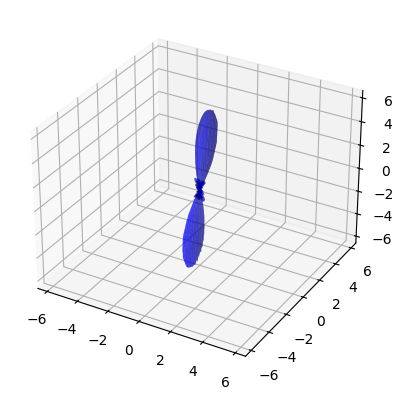

In [8]:
fig, ax = odf3.visualize_odf(ODFs[80,19,9], 64, 64)
plt.show()

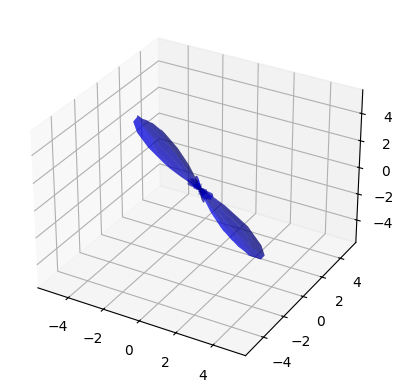

In [9]:
fig, ax = odf3.visualize_odf(ODFs[81,19,9], 64, 64)
plt.show()